In [1]:
import sys
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL.Image
%matplotlib inline

## Check Versions

In [2]:
print(f"Tensor Flow version: {tf.__version__}")
print(f"Python version: {sys.version}")
print(f"Numpy version: {np.__version__}")
gpu = len(tf.config.list_physical_devices("GPU"))>0
print("GPU is", "available" if gpu else "not available")

Tensor Flow version: 2.3.0
Python version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Numpy version: 1.19.2
GPU is not available


## Reference:
### https://www.tensorflow.org/tutorials/generative/style_transfer

### Tensor to image

In [3]:
def tensor_to_img(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

### Load image and resize to correct dimensions (1024x768)

In [4]:
def load_img(img_path):
    max_dim = 512
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=3) #Decode image to a tensor
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :] #Broadcasting image array to fit bacth dimension
    
    return img

### Plot image

In [5]:
def show_image(img, title=None):
    if (len(img.shape) > 3): #Keep the dimension of W(=width),H(=height),c(=channel)
        img = np.squeeze(img, axis=0)
    plt.imshow(img)
    if (title):
        plt.title(title)

### Examine the images

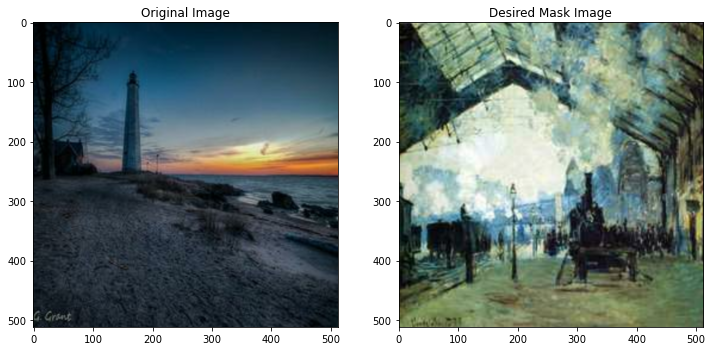

In [6]:
original_img = load_img('./images/original_jpg/6736ee186d.jpg')
desired_mask_img = load_img('./images/monet_mask_jpg/95b5f01a85.jpg')

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
show_image(original_img, title="Original Image")
plt.subplot(1,2,2)
show_image(desired_mask_img, title="Desired Mask Image")

In [7]:
print(f"Original Image Shape: {original_img.shape}")
print(f"Desired Mask Image Shape: {desired_mask_img.shape}")

Original Image Shape: (1, 512, 512, 3)
Desired Mask Image Shape: (1, 512, 512, 3)


### Define original and desired representations

In [8]:
x = tf.keras.applications.vgg19.preprocess_input(original_img * 255) #Initialize model by preprocessing
x = tf.image.resize(x, (256,256)) #Input size for VGG19 model
vgg_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
vgg_model.trainable=False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### Pick layers to replace with original and desired mask from the original model architecture

In [9]:
original_image_layers = ["block4_conv2"]
desired_mask_layers = ["block1_conv1",
                    "block2_conv1",
                    "block3_conv1",
                    "block4_conv1",
                    "block5_conv1"]
num_original_image_layers = len(original_image_layers)
num_desired_mask_layers = len(desired_mask_layers)

# Build model

In [10]:
def custom_vgg_model(layer_names):
    #Creates a VGG model that returns a list of intermediate output values
    vgg_model = tf.keras.applications.VGG19(include_top=False, weights="imagenet")
    vgg_model.trainable=False
    outputs = [vgg_model.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg_model.input], outputs)
    return model

### Extract styles

In [11]:
style_extractor = custom_vgg_model(desired_mask_layers)
style_extractor_output = style_extractor(desired_mask_img*255)

#Information on the layers
for name, output in zip(desired_mask_layers, style_extractor_output):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())

block1_conv1
  shape:  (1, 512, 512, 64)
  min:  0.0
  max:  845.75525
  mean:  22.120089
block2_conv1
  shape:  (1, 256, 256, 128)
  min:  0.0
  max:  2100.1633
  mean:  125.34044
block3_conv1
  shape:  (1, 128, 128, 256)
  min:  0.0
  max:  6015.9194
  mean:  116.5423
block4_conv1
  shape:  (1, 64, 64, 512)
  min:  0.0
  max:  12791.038
  mean:  452.98804
block5_conv1
  shape:  (1, 32, 32, 512)
  min:  0.0
  max:  1672.8721
  mean:  35.003727


### Compute the gram matrix using Einsum

#### Define tensors by the sum of their element wise cumputation

In [12]:
def gram_matrix(input_tensor): #Shape of input is: ch, n_H, n_W
    result = tf.linalg.einsum("bijc,bijd->bcd", input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32) #Unrolls n_H and n_W
    
    
    return result/(num_locations)

### Build model that returns the original and desired tensors

In [13]:
class StyleTransferModel(tf.keras.models.Model):
    def __init__(self, desired_mask_layers, original_image_layers):
        super(StyleTransferModel, self).__init__()
        self.vgg = custom_vgg_model(desired_mask_layers + original_image_layers)
        self.desired_mask_layers = desired_mask_layers
        self.original_image_layers = original_image_layers
        self.num_desired_mask_layers = len(desired_mask_layers)
        self.vgg.trainable = False
    
    def call(self, inputs):
        #Expects floats inputs in [0,1]"
        inputs = inputs*255.0 #Scale back pixel values
        preprocessed_inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_inputs)
        
        #Separate representation of desired mask and original image
        desired_outputs, original_outputs = (outputs[:self.num_desired_mask_layers],
                                             outputs[self.num_desired_mask_layers:])
        
        #Calculate the gram matrix of each layer from the desired output
        desired_outputs = [gram_matrix(layer)
                           for layer in desired_outputs]
        
        #Store original and desired representations into dictionaries
        original_dict = {original_name:value
                         for original_name, value
                         in zip(self.original_image_layers, original_outputs)}
        desired_dict = {desired_name:value
                        for desired_name, value
                        in zip(self.desired_mask_layers, desired_outputs)}
        
        #Returns a dictionary consisting of 2 dictionaries: (1)contents of the orginal image layers 
        #and (2)gram matrix of desired mask
        return {"Original Image":original_dict, "Desired Mask":desired_dict}

### Lets have a look at the gram matrix of a <u>desired mask</u> and the contents of the <u>original image</u>

In [14]:
#We need to extract the desired and original representation for gradient descent
extractor = StyleTransferModel(desired_mask_layers, original_image_layers)
results = extractor(tf.constant(original_img))

print("Styles:")
for name, output in sorted(results["Desired Mask"].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()
print("Contents:")
for name, output in sorted(results["Original Image"].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.00012778249
    max:  27557.336
    mean:  436.76825

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  53387.266
    mean:  7868.4897

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  260623.28
    mean:  6644.0635

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2766092.2
    mean:  110845.19

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  34260.387
    mean:  556.9949

Contents:
   block4_conv2
    shape:  (1, 64, 64, 512)
    min:  0.0
    max:  11554.05
    mean:  183.20195



## Running gradient descent

In [15]:
#With the extractor in place, it's time to implement the transfer algorithm. 
#We calculate the mean square error for the images output relative to each target. 
#After, we take the weighted sum of these losses

#Set the extractors outputs as target values:
desired_targets = extractor(desired_mask_img)["Desired Mask"]
original_targets = extractor(original_img)["Original Image"]

In [16]:
#Define a tf.variable to contain the generated image from the desired and original images
generated_image = tf.Variable(original_img)#tf.Variable must be the same shape as original_img

In [17]:
#This is a floated image. So we need to keep the pixel values between 0 to 1
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [18]:
#Adam optimizer (the paper recommend LBFGS)
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [19]:
#To optimize, used the weighted combination of the two losses to get the total loss
desired_weight = 1e-2
original_weight = 1e3

def total_cost(outputs):
    desired_outputs = outputs["Desired Mask"]
    original_outputs = outputs["Original Image"]
    
    desired_loss = tf.add_n([tf.reduce_mean((desired_outputs[name]-desired_targets[name])**2)
                            for name in desired_outputs.keys()])
    desired_loss *= desired_weight/num_desired_mask_layers
    
    original_loss = tf.add_n([tf.reduce_mean((original_outputs[name]-original_targets[name])**2)
                             for name in original_outputs.keys()])
    original_loss *= original_weight/num_original_image_layers
    
    loss = desired_loss+original_loss
    return loss

In [20]:
#Update the image
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = total_cost(outputs)
        
        grad = tape.gradient(loss, image)
        opt.apply_gradients([(grad, image)])
        image.assign(clip_0_1(image))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

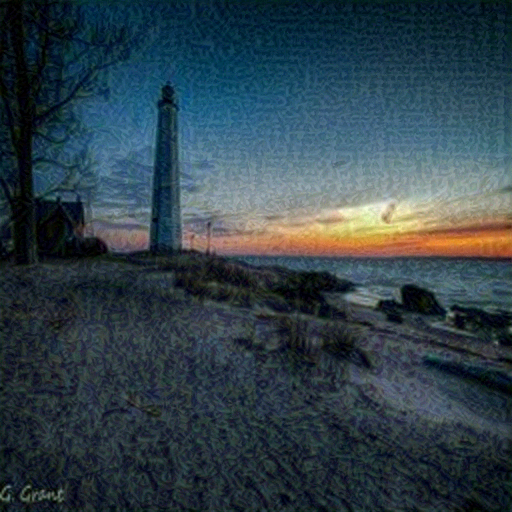

In [21]:
#Run 3 steps to test
train_step(generated_image)
train_step(generated_image)
train_step(generated_image)
tensor_to_img(generated_image)

In [27]:
#Longer optimization - Option #1 - Left it running for 1 hour and it didn't finish.
#num_iterations = 2500
#for i in range(num_iterations):
#    train_step(generated_image)
#    if(i%500 == 0):
#        plt.figure(figsize=(12,12))
#        plt.subplot(1,3,1)
#        show_image(original_img, "Original Image")
#        plt.subplot(1,3,2)
#        show_image(desired_mask_img, "Desired Image")
#        plt.subplot(1,3,3)
#        show_image(np.squeeze(generated_image.read_value(), 0), "Generated Image, Step: " + str(i))
    

In [29]:
#Longer optimization - Option #2 - Seems like it takes a long time to run as well.
#start = time.time()

#epochs = 10
#steps_per_epoch = 100

#step = 0
#for i in range(epochs):
#    for ii in range(steps_per_epoch):
#        step += 1
#        train_step(generated_image)
#        print(".", end="")
#    display.clear_output(wait=True)
#    display.display(tensor_to_img(generated_image))
#    print("Train Step: {}".format(step))
#
#end = time.time()
#print("Total Time: {:.1f}".format(end-start))
    